In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings

warnings.filterwarnings(action = 'ignore')
%matplotlib inline

# data load

In [2]:
# 1. err data 
train_err  = pd.read_csv('train_err_data.csv')
test_err  = pd.read_csv('test_err_data.csv')

# 전처리의 용이함을 위해 concat. 언제나 data leakage 유의.
df = pd.concat([train_err, test_err])
display(df.head())
df.shape

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


(33087311, 6)

In [33]:
# 2. qrt data
train_qrt = pd.read_csv('train_quality_data.csv', thousands = ',')
test_qrt = pd.read_csv('test_quality_data.csv', thousands = ',')

# 전처리의 용이함을 위해 concat. 언제나 data leakage 유의.
df_qlt = pd.concat([train_qrt, test_qrt])
display(df_qlt.head())
df_qlt.shape

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0,0,0.0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0,0,0.0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0,0,0.0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0,0,0.0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0,0,0.0,0,0,0,0,4,0,0


(1576596, 16)

In [4]:
# 3.target
train_prob = pd.read_csv('train_problem_data.csv')
train_prob.head()

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


In [5]:
train_y = np.zeros(15000)

# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
train_y[train_prob.user_id.unique()-10000] = 1 
train_y

'\n이 부분도 한 번 생각해 볼 여지가 있음. 과연 저 논리가 맞을까? \n일단 쉬우니까 하긴 했다만...\n'

# preprocessing

In [6]:
import datetime as dt
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    mim  = int(x[10:12])
    sec  = int(x[12:])
    return dt.datetime(year, month, day, hour, mim, sec)

df['datetime'] = df['time'].apply(make_datetime)
# 요일명
df['day_of_week'] = df['datetime'].dt.day_name()
# 주말여부
df['weekend'] = df['day_of_week'].apply(lambda x : 1 if x == "Sunday" or x == 'Saturday' else 0)


In [7]:
# 고객별 발생 errtype count
f1 = pd.pivot_table(df, index = 'user_id', columns = 'errtype', values = 'time', aggfunc = len, fill_value = 0) ; f1

errtype,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
user_id,,,,,,,,,,,,,,,,,,,,,
10000,0,0,8,104,0,1,1,0,0,7,...,0,0,0,0,0,0,0,0,0,0
10001,0,0,0,0,53,1,1,0,0,0,...,10,18,0,1,1,0,0,113,56,1
10002,0,0,2,132,1,2,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10003,0,0,0,0,2,1,1,0,0,0,...,8,0,0,1,1,2,0,17,1,0
10004,0,0,0,1,0,3,4,0,0,0,...,16,0,0,1,1,0,0,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,0,0,0,2,12,5,5,0,0,0,...,16,0,0,0,0,0,0,100,87,0
44995,0,0,0,0,0,2,2,0,0,0,...,14,1,0,1,1,0,0,12,17,0
44996,0,0,0,0,0,1,1,0,0,0,...,12,1118,0,1,1,1,0,329,2,3


In [8]:
# 고객별 사용 model count
f2 = pd.pivot_table(df, index = 'user_id', columns = 'model_nm', values = 'time', aggfunc = len, fill_value = 0) ; f2

model_nm,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
user_id,,,,,,,,,
10000,0,0,0,317,0,0,0,0,0
10001,0,0,2365,0,0,0,0,0,0
10002,0,0,0,306,0,0,0,0,0
10003,0,0,306,0,0,0,0,0,0
10004,777,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
44994,0,1115,0,0,0,0,0,0,0
44995,515,0,0,0,0,0,0,0,0
44996,2233,0,0,0,0,0,0,0,0


In [9]:
# 고객별 발생 errcode count
f3 = pd.pivot_table(df, index = 'user_id', columns = 'errcode', values = 'time', aggfunc = len, fill_value = 0) ; f3

errcode,-1010,-269,-270,0,0001,1,100,10005,10018,10020,...,connection fail to establish,connection timeout,connectionterminated by local host,eDes,http,"me=""",scanning timeout,standby,tVer,terminate by peer user
user_id,,,,,,,,,,,,,,,,,,,,,
10000,0,0,0,104,0,212,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10001,0,0,0,183,0,1274,0,0,0,0,...,0,0,0,0,0,0,0,625,0,0
10002,0,0,0,132,0,172,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003,0,0,0,42,0,229,0,0,0,0,...,0,7,0,0,0,0,0,0,0,0
10004,0,0,0,98,0,529,0,0,0,0,...,1,104,0,0,0,0,0,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,0,0,0,139,0,624,0,0,0,0,...,7,197,0,0,0,0,0,0,0,0
44995,0,0,0,105,0,370,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44996,0,0,0,251,0,698,0,0,0,0,...,4,44,0,0,0,0,0,11,0,2


In [10]:
# 고객별 로그 기록 요일
f4 = pd.pivot_table(df, index = 'user_id', columns = 'day_of_week', values = 'time', aggfunc = len, fill_value = 0) ; f4

day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
user_id,,,,,,,
10000,43,37,54,52,45,41,45
10001,1534,164,117,139,166,138,107
10002,34,52,42,58,40,34,46
10003,37,51,22,57,45,52,42
10004,171,96,84,108,59,144,115
...,...,...,...,...,...,...,...
44994,154,177,116,245,139,133,151
44995,74,83,71,78,68,86,55
44996,413,223,419,533,272,204,169


In [11]:
# 고객별 quality의 합, 평균, 중위값
f5 = df_qlt.groupby('user_id')[[f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]].sum()
f6 = df_qlt.groupby('user_id')[[f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]].mean()
f7 = df_qlt.groupby('user_id')[[f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]].median()

In [12]:
# 고객이 불만을 제기한 시간대에서, 발생한 (errcode+errtype)의 빈도만큼 가중치를 주는 feature

from tqdm import tqdm
err_temp = train_err.copy()
err_temp['temp_merge'] = err_temp['time'].apply(lambda x : str(x)[:-4])
prob_temp = train_prob.copy()
prob_temp['problem'] = 1
prob_temp['temp_merge'] = prob_temp.time.apply(lambda x : str(x)[:-4]) ; prob_temp.head()

err_prob_df = pd.merge(err_temp, prob_temp, how = 'left', left_on = ['user_id','temp_merge'], right_on = ['user_id', 'temp_merge'])

temp_df = pd.DataFrame()
for i in tqdm(range(9)):
    temp = pd.pivot_table(err_prob_df.query(f'problem == 1 and model_nm == "model_{i}"'), index = 'errtype', columns = 'errcode', aggfunc = len, values = 'problem', fill_value = 0)#.at[1, '0']
    temp2 = df.query(f'model_nm == "model_{i}"')
    def find_errtype_errcode(x, y):
        if x in temp.index and y in temp.columns:
            if temp.at[x,y] > 0:
                return temp.at[x,y]
            else:
                return 0
        else:
            return 0
        
    temp2['problem_occur'] = temp2.apply(lambda x : find_errtype_errcode(x['errtype'], x['errcode']), axis = 1)
    temp_df = pd.concat([temp_df, temp2])
    
f8 = temp_df.sort_values(by = 'user_id').groupby('user_id')['problem_occur'].sum()
f9 = temp_df.sort_values(by = 'user_id').groupby('user_id')['problem_occur'].mean()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [10:22<00:00, 69.15s/it]


In [13]:
df['day'] = df.datetime.dt.day

# feature. 고객별 날짜 횟수
f10 = pd.pivot_table(df, index = 'user_id', columns = 'day', aggfunc = 'count', values = 'time', fill_value = 0)

In [14]:
# feature. 시간대 분위수 사용량
## percentage로 할지?

df['hour'] = df.datetime.dt.hour
df['hour_quantile'] = df.hour.apply(lambda x : 1 if x >= 0 and x < 6 else(
                                                        2 if x >= 6 and x < 12 else(
                                                        3 if x >= 12 and x < 18 else 4)))

temp = pd.concat([df.user_id, pd.get_dummies(df.hour_quantile)], axis = 1) ; temp
f11 = temp.groupby('user_id')[[1,2,3,4]].sum()

In [15]:
# 고객별 사용 fwver percentage
def percentage_pivot(df, columns, index, values, aggfunc = len, fill_value = 0):
    f = pd.pivot_table(df, columns = columns, index = index, values = values, aggfunc = aggfunc, fill_value = fill_value, margins = True)
    f2 = f.div(f.iloc[:, -1], axis = 0)
    return f2.iloc[:-1, :-1]
f13 = percentage_pivot(df, index = 'user_id', columns = 'fwver', values = 'model_nm', aggfunc = len, fill_value = 0)

In [16]:
# 펌웨어 변동 횟수
f14 = np.zeros(29998)
for i in f13.columns:
    temp2 = f13[i].apply(lambda x : 0 if x == 1 or x == 0 else 1)
    f14 += temp2

In [17]:
# errtype + errcode -> pivot
df_temp = df.copy()
df_temp['typecode'] = df_temp.errtype.astype('str') + '_' + df_temp.errcode.astype('str')
f15 = pd.pivot_table(df_temp[['user_id','typecode','fwver']], index = 'user_id',columns = 'typecode',values = 'fwver', aggfunc = len, fill_value = 0)

# PCA로 줄이면 성능이 확 떨어짐.
'''from sklearn.decomposition import PCA
# PCA
max_col = temp.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(temp)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99) + 1

# num_col 이 1이었기 때문에 num_col은 max_col이 되었다

if num_col == 1:
    num_col = max_col

pca = PCA(n_components = num_col, random_ㅠstate=0).fit_transform(temp)

f15 = pd.DataFrame(pca)
'''

'from sklearn.decomposition import PCA\n# PCA\nmax_col = temp.shape[1]\npca = PCA(n_components=max_col, random_state=0).fit(temp)\n\ncumsum = np.cumsum(pca.explained_variance_ratio_)\nnum_col = np.argmax(cumsum >= 0.99) + 1\n\n# num_col 이 1이었기 때문에 num_col은 max_col이 되었다\n\nif num_col == 1:\n    num_col = max_col\n\npca = PCA(n_components = num_col, random_ㅠstate=0).fit_transform(temp)\n\nf15 = pd.DataFrame(pca)\n'

---

In [34]:
# quality data 전처리
df_qlt['datetime'] = df_qlt['time'].apply(make_datetime)
# 요일명
df_qlt['day_of_week'] = df_qlt['datetime'].dt.day_name()
# 주말여부
df_qlt['weekend'] = df_qlt['day_of_week'].apply(lambda x : 1 if x == "Sunday" or x == 'Saturday' else 0)
df_qlt = df_qlt.drop(['quality_3','quality_4'], axis = 1)

df_qlt['day'] = df_qlt.datetime.dt.day

In [20]:
# fwver, model_nm을 기준으로 결측치를 채우려고 했음. (fillna(by = model_nm))하지만 성능이 좋지 않아서 주석처리함.
'''# df_qlt model nm
pp = pd.pivot_table(df, index = 'model_nm', columns = 'fwver', aggfunc = len, values = 'time').T
pp = dict(pp)

for key in pp.keys():
    pp[key] = pp[key].dropna()
    pp[key] = pp[key].index.tolist()

def find_model(x):
    for key, value in pp.items():
        if x in value:
            return key
    return np.nan

df_qlt['model_nm'] = df_qlt.fwver.apply(lambda x : find_model(x))'''

'''# 병합용 index
USER_ID = pd.DataFrame([i for i in range(10000, 25000)] + [j for j in range(30000, 44999)])
USER_ID.columns = ['user_id']

temp = df[['user_id','model_nm']].drop_duplicates().reset_index(drop = True)
temp = pd.pivot_table(temp, index = 'user_id', columns = 'model_nm', aggfunc = len).T
temp = dict(temp)

for key in temp.keys():
    temp[key] = temp[key].dropna().index.tolist()

temp = pd.DataFrame(pd.Series(temp)).reset_index()
temp.columns = ['user_id','model_nm']

USER_ID = pd.merge(USER_ID, temp, how = 'left')'''

In [36]:
# 사용자별 -1 발생 횟수 count.
minus_count = []
for i in [0, 1, 2, 5, 6, 11 ]:
    minus_count.append(df_qlt[df_qlt[f'quality_{i}'] == -1].groupby('user_id')[f'quality_{i}'].count())

f17 = pd.concat([i for i in minus_count], axis = 1, ignore_index = True).mean(axis = 1)

In [37]:
# 데이터가 왜도가 심하므로, 로그변환을 두번 취해줌.
for i in [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]:
    df_qlt[i] = np.log1p(df_qlt[i])
    df_qlt[i].fillna(0, inplace = True)
    df_qlt[i] = np.log1p(df_qlt[i])
    df_qlt[i].fillna(0, inplace = True)

print('log 변환 완료')

log 변환 완료


In [50]:
# 고객별 quality count
f28 = df_qlt.groupby('user_id')['time'].count()/12

In [38]:
# quality 일별 평균, 최대값
'''t1 = pd.pivot_table(df_qlt, index = 'model_nm', columns = 'day',values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'mean', fill_value = 0)
t2 = pd.pivot_table(df_qlt, index = 'user_id', columns = 'day',values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'mean', fill_value = 0)
t3 = pd.merge(USER_ID, t2.reset_index(), left_on = 'user_id', right_on = 'user_id', how = 'left')
t4 = t3[t3.iloc[:, 2].isna()]

t4.model_nm = t4.model_nm.str[0]
t4 = t4.iloc[:, :2]
t5 = pd.merge(t4, t1, how = 'left', left_on = 'model_nm', right_on = ff.index)

t2.columns = [i for i in range(t2.shape[1])]
t5.index = t5.user_id
t5 = t5.iloc[:, 2:]
t5.columns = [i for i in range(t2.shape[1])]
f = pd.concat([t2, t5])

# quality 일별 평균
f16 = f.reset_index().sort_values(by = 'user_id').iloc[:,1:].reset_index(drop = True)
'''
f16 = pd.pivot_table(df_qlt, index = 'user_id', columns = 'day',values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'mean', fill_value = 0)
f16_5 = pd.pivot_table(df_qlt, index = 'user_id', columns = 'day',values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'max', fill_value = 0)


In [25]:
# 일별 quality 합
'''t1 = pd.pivot_table(df_qlt, index = 'model_nm', columns = 'day',values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'sum', fill_value = 0)
t2 = pd.pivot_table(df_qlt, index = 'user_id', columns = 'day',values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'sum', fill_value = 0)
t3 = pd.merge(USER_ID, t2.reset_index(), left_on = 'user_id', right_on = 'user_id', how = 'left')
t4 = t3[t3.iloc[:, 2].isna()]

t4.model_nm = t4.model_nm.str[0]
t4 = t4.iloc[:, :2]
t5 = pd.merge(t4, t1, how = 'left', left_on = 'model_nm', right_on = ff.index)

t2.columns = [i for i in range(t2.shape[1])]
t5.index = t5.user_id
t5 = t5.iloc[:, 2:]
t5.columns = [i for i in range(t2.shape[1])]
f = pd.concat([t2, t5])

# quality 일별 합
f17 = f.reset_index().sort_values(by = 'user_id').iloc[:,1:].reset_index(drop = True)

f19 = pd.pivot_table(df_qlt, index = 'user_id', columns = 'day',values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'sum', fill_value = 0)

In [26]:
'''# 0값 제거
df_qlt = df_qlt.drop(['quality_3','quality_4'], axis = 1)
# 한번이라도 qlt data에 기록된 user_id
t1 = np.zeros(15000)
t2 = np.zeros(14998)
t1[np.array([i for i in df_qlt.user_id.unique() if i <= 25000])-10000] = 1 
t2[np.array([i for i in df_qlt.user_id.unique() if i >= 30000])-30000] = 1 
f16 = pd.DataFrame(np.concatenate([t1, t2]))'''

"# 0값 제거\ndf_qrt = df_qrt.drop(['quality_3','quality_4'], axis = 1)\n# 한번이라도 qlt data에 기록된 user_id\nt1 = np.zeros(15000)\nt2 = np.zeros(14998)\nt1[np.array([i for i in df_qrt.user_id.unique() if i <= 25000])-10000] = 1 \nt2[np.array([i for i in df_qrt.user_id.unique() if i >= 30000])-30000] = 1 \nf16 = pd.DataFrame(np.concatenate([t1, t2]))"

In [39]:
# 중복 제거 후, 고객별 퀄리티 평균
f18 = df_qlt.drop_duplicates().groupby('user_id')[[f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]].mean()

In [54]:
# 요일별 퀄리티 평균, 최댓값
f29 = pd.pivot_table(df_qlt, index = 'user_id', columns = 'day_of_week', values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'mean', fill_value = 0)
f30 = pd.pivot_table(df_qlt, index = 'user_id', columns = 'day_of_week', values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'max', fill_value = 0)

In [57]:
# 고객별 왜도
f31 = df_qlt.groupby('user_id')[[f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]].skew()

In [73]:
# 고객의 시간대별 평균, 최대값, 빈도 
df_qlt['hour'] = df_qlt.datetime.dt.hour
df_qlt['hour_quantile'] = df_qlt.hour.apply(lambda x : 1 if x >= 0 and x < 6 else(
                                                        2 if x >= 6 and x < 12 else(
                                                        3 if x >= 12 and x < 18 else 4)))

temp = pd.concat([df_qlt.loc[:,'user_id':'quality_12'], pd.get_dummies(df_qlt.hour_quantile)], axis = 1) ; temp
f32 = pd.pivot_table(temp, index = 'user_id', columns = [1,2,3,4], values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'mean', fill_value = 0)
f33 = pd.pivot_table(temp, index = 'user_id', columns = [1,2,3,4], values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'max', fill_value = 0)
f34 = pd.pivot_table(temp, index = 'user_id', columns = [1,2,3,4], values = [f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]], aggfunc = 'count', fill_value = 0)/12

In [76]:
# 고객별 quality변동계수
f35 = df_qlt.groupby('user_id')[[f'quality_{i}' for i in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]].apply(lambda x : np.std(x) / np.mean(x))
f35.fillna(0, inplace = True)

In [77]:
# 0, -1을 제외한 평균, 합, 중위수
f19 = pd.DataFrame()
f20 = pd.DataFrame()
f21 = pd.DataFrame()

for i in [f'quality_{j}' for j in [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]:
    f19 = pd.concat([f19, df_qlt.query(f'{i} != 0 and {i} != -1').groupby('user_id')[i].mean()], axis = 1)
    f20 = pd.concat([f19, df_qlt.query(f'{i} != 0 and {i} != -1').groupby('user_id')[i].sum()], axis = 1)
    f21 = pd.concat([f19, df_qlt.query(f'{i} != 0 and {i} != -1').groupby('user_id')[i].median()], axis = 1)

In [78]:
# 재준 feature
train_err.time = pd.to_datetime(train_err.time, format='%Y%m%d%H%M%S')

peri = pd.Series((train_err.groupby(['user_id'])['time'].max() - train_err.groupby(['user_id'])['time'].min())/train_err.groupby(['user_id'])['time'].count())

p_min = pd.Series(train_err.groupby(['user_id'])['time'].min().astype(np.int64))
p_max = pd.Series(train_err.groupby(['user_id'])['time'].max().astype(np.int64))
p_1q = pd.Series(train_err.groupby(['user_id'])['time'].quantile(.25).astype(np.int64))
p_2q = pd.Series(train_err.groupby(['user_id'])['time'].quantile(.50).astype(np.int64))
p_3q = pd.Series(train_err.groupby(['user_id'])['time'].quantile(.75).astype(np.int64))

train_err['new'] = train_err['time'].values.astype(np.int64)

p_std = train_err.groupby('user_id')['new'].var()**.5

In [79]:
# 고객별 발생 errtype count percentage
f22 = percentage_pivot(df, index = 'user_id', columns = 'errtype', values = 'time', aggfunc = len, fill_value = 0) ; f22

errtype,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
user_id,,,,,,,,,,,,,,,,,,,,,
10000,0.0,0.0,0.025237,0.328076,0.000000,0.003155,0.003155,0.0,0.0,0.022082,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
10001,0.0,0.0,0.000000,0.000000,0.022410,0.000423,0.000423,0.0,0.0,0.000000,...,0.004228,0.007611,0.0,0.000423,0.000423,0.000000,0.0,0.047780,0.023679,0.000423
10002,0.0,0.0,0.006536,0.431373,0.003268,0.006536,0.003268,0.0,0.0,0.003268,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
10003,0.0,0.0,0.000000,0.000000,0.006536,0.003268,0.003268,0.0,0.0,0.000000,...,0.026144,0.000000,0.0,0.003268,0.003268,0.006536,0.0,0.055556,0.003268,0.000000
10004,0.0,0.0,0.000000,0.001287,0.000000,0.003861,0.005148,0.0,0.0,0.000000,...,0.020592,0.000000,0.0,0.001287,0.001287,0.000000,0.0,0.005148,0.000000,0.002574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,0.0,0.0,0.000000,0.001794,0.010762,0.004484,0.004484,0.0,0.0,0.000000,...,0.014350,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.089686,0.078027,0.000000
44995,0.0,0.0,0.000000,0.000000,0.000000,0.003883,0.003883,0.0,0.0,0.000000,...,0.027184,0.001942,0.0,0.001942,0.001942,0.000000,0.0,0.023301,0.033010,0.000000
44996,0.0,0.0,0.000000,0.000000,0.000000,0.000448,0.000448,0.0,0.0,0.000000,...,0.005374,0.500672,0.0,0.000448,0.000448,0.000448,0.0,0.147335,0.000896,0.001343


In [80]:
# 고객별 사용 model count percentage
f23 = percentage_pivot(df, index = 'user_id', columns = 'model_nm', values = 'time', aggfunc = len, fill_value = 0) ; f23

model_nm,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
user_id,,,,,,,,,
10000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10002,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10003,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
44994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# 고객별 발생 errcode count percentage
f24 = percentage_pivot(df, index = 'user_id', columns = 'errcode', values = 'time', aggfunc = len, fill_value = 0) ; f24

errcode,-1010,-269,-270,0,0001,1,100,10005,10018,10020,...,connection fail to establish,connection timeout,connectionterminated by local host,eDes,http,"me=""",scanning timeout,standby,tVer,terminate by peer user
user_id,,,,,,,,,,,,,,,,,,,,,
10000,0.0,0.0,0.0,0.328076,0.0,0.668770,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
10001,0.0,0.0,0.0,0.077378,0.0,0.538689,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.264271,0.0,0.000000
10002,0.0,0.0,0.0,0.431373,0.0,0.562092,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
10003,0.0,0.0,0.0,0.137255,0.0,0.748366,0.0,0.0,0.0,0.0,...,0.000000,0.022876,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
10004,0.0,0.0,0.0,0.126126,0.0,0.680824,0.0,0.0,0.0,0.0,...,0.001287,0.133848,0.000000,0.0,0.0,0.0,0.000000,0.006435,0.0,0.002574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44994,0.0,0.0,0.0,0.124664,0.0,0.559641,0.0,0.0,0.0,0.0,...,0.006278,0.176682,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
44995,0.0,0.0,0.0,0.203883,0.0,0.718447,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
44996,0.0,0.0,0.0,0.112405,0.0,0.312584,0.0,0.0,0.0,0.0,...,0.001791,0.019704,0.000000,0.0,0.0,0.0,0.000000,0.004926,0.0,0.000896


In [82]:
# 고객별 로그 기록 요일 percentage
f25 = percentage_pivot(df, index = 'user_id', columns = 'day_of_week', values = 'time', aggfunc = len, fill_value = 0) ; f25

day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
user_id,,,,,,,
10000,0.135647,0.116719,0.170347,0.164038,0.141956,0.129338,0.141956
10001,0.648626,0.069345,0.049471,0.058774,0.070190,0.058351,0.045243
10002,0.111111,0.169935,0.137255,0.189542,0.130719,0.111111,0.150327
10003,0.120915,0.166667,0.071895,0.186275,0.147059,0.169935,0.137255
10004,0.220077,0.123552,0.108108,0.138996,0.075933,0.185328,0.148005
...,...,...,...,...,...,...,...
44994,0.138117,0.158744,0.104036,0.219731,0.124664,0.119283,0.135426
44995,0.143689,0.161165,0.137864,0.151456,0.132039,0.166990,0.106796
44996,0.184953,0.099866,0.187640,0.238692,0.121809,0.091357,0.075683


In [83]:
# feature. 고객별 날짜 횟수percentage
f26 = percentage_pivot(df, index = 'user_id', columns = 'day', aggfunc = 'count', values = 'time', fill_value = 0)

In [84]:
# percentage
df_temp = df.copy()
df_temp['typecode'] = df_temp.errtype.astype('str') + '_' + df_temp.errcode.astype('str')
f27 = percentage_pivot(df_temp[['user_id','typecode','fwver']], index = 'user_id',columns = 'typecode',values = 'fwver', aggfunc = len, fill_value = 0)


In [85]:
# 토론에서 나온 features
tre_raw = pd.read_csv('train_err_data.csv')
tp = pd.read_csv('train_problem_data.csv')


tpd=tp.user_id.value_counts().to_frame().reset_index()
tpd.columns = ['user_id','count_e']
tre = pd.merge(tre_raw,tpd,on='user_id',how='outer')
tre.count_e =tre.count_e.fillna(0).astype('int')


tse = pd.read_csv("test_err_data.csv")

tre.time =pd.to_datetime(tre.time.astype('str'))
tse.time =pd.to_datetime(tse.time.astype('str'))

def check_unique(col,df1,df2):
    def change_len(x):
        if len(x) ==10:
            return x[:5]
        else:
            return x
    print("about",col)
    if col !='fwvers':
        train_c = set(df1[col].unique())
        test_c  = set(df2[col].unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)
    else:
        train_c = set(df1[col].apply(change_len).unique())
        test_c  = set(df2[col].apply(change_len).unique())
        print("train only in %s "%col,train_c-test_c)
        print("test only in %s "%col,test_c -train_c)
        total = (train_c | test_c)        
        
    print()
        
    return total

model_total=check_unique('model_nm',train_err,test_err)
errtype_total=check_unique('errtype',train_err,test_err)
fwver_total = check_unique('fwver',train_err,test_err)

def dataset_trans(df,types,Num_df_user,Num_errtype,First_index):
    
    
    num_df_user = Num_df_user
    num_errtype =Num_errtype
    first_index = First_index
    num_model_change =2

    
    #----------------------------------------------errtype
    errtypes = np.zeros((num_df_user,num_errtype))
    err = df[['user_id','errtype']].values

    for inx, value in tqdm(err):
        errtypes[inx-first_index,value-1] +=1


    # ---------------------------------------------model_change
    v=df[['user_id','model_nm']]
    getdf =~(v == v.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.model_nm.apply(int)) > 0
    df_model_counts =v[logical]


    def get_model_change_id(num):
        df_mc = df_model_counts.user_id.value_counts()
        df_mc_user=list(df_mc.loc[df_mc ==num].to_frame().index)
        sort_mc_user = df.loc[df.user_id.isin(df_mc_user)].drop_duplicates(['user_id','model_nm'],keep='last').drop_duplicates('user_id',keep='first').sort_values("time").user_id
        return sort_mc_user.values

    one_m = get_model_change_id(1)
    two_m = get_model_change_id(2)
    thr_m = get_model_change_id(3)


    model_n = np.zeros((num_df_user,num_model_change))
    df['model_f'] =df['model_nm'].str[-1].astype('int')
    one_df = df.loc[df.user_id.isin(one_m)][['user_id','model_f']].drop_duplicates().values
    two_df =df.loc[df.user_id.isin(two_m)][['user_id','model_f']].drop_duplicates().reset_index(drop=True)
    two_df['tf'] = two_df.index%2
    two_df= two_df.pivot(index='user_id',columns='tf').reset_index().values
    thr_df = df.loc[df.user_id.isin(thr_m)][['user_id','model_f']].drop_duplicates().values

    for inx, value in tqdm(one_df):
        model_n[inx-first_index,0]  +=value
    for inx, value1,value2 in tqdm(two_df):
        model_n[inx-first_index,0]  +=value1
        model_n[inx-first_index,1]  +=value2

    for inx, value in tqdm(thr_df):
        model_n[inx-first_index,0]  +=value


    # ---------------------------------------------fw change
    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1

    def fwver_tran(x):
        return fwver_total_dic[x]


    df['ver_num'] = df['fwver'].apply(fwver_tran)
    fwver_np = np.zeros((num_df_user,5))

    v3=df[['user_id','ver_num']]
    getdf =~(v3 == v3.shift(1))
    logical =(getdf.user_id.apply(int) + getdf.ver_num.apply(int)) > 0
    fwver_num=v3[logical]

    fwver_num = fwver_num.reset_index(drop=True)
    count =np.zeros(len(fwver_num),dtype=int)

    for v in range(1,len(fwver_num)):
        if fwver_num.user_id.values[v-1] ==fwver_num.user_id.values[v]:
            count[v] = count[v-1] +1


    fwver_num['count'] =count
    fw_v = fwver_num.loc[fwver_num['count'].isin([0,1,2,3,4])].pivot(index='user_id',columns='count').reset_index().fillna(0).values
    fw_v =fw_v.astype('int64')

    
    
    
    for inx, v1,v2,v3,v4,v5 in tqdm(fw_v):
        fwver_np[inx-first_index,0] =v1
        fwver_np[inx-first_index,1] =v2
        fwver_np[inx-first_index,2] =v3
        fwver_np[inx-first_index,3] =v4
        fwver_np[inx-first_index,4] =v5

    #---------------------------------------------------------- errtype_ mean_std
    df['week'] =df.time.dt.isocalendar().week

    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','week']]
    df_=datas[['user_id','week','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','week']).rename(columns = {0:'counts'}).reset_index(drop=True)

    df1 =df_.loc[df_.week ==44][['user_id','errtype','counts']].values
    df2 =df_.loc[df_.week ==45][['user_id','errtype','counts']].values
    df3 =df_.loc[df_.week ==46][['user_id','errtype','counts']].values
    df4 =df_.loc[df_.week ==47][['user_id','errtype','counts']].values
    df5 =df_.loc[df_.week ==48][['user_id','errtype','counts']].values

    day_data = np.zeros((num_df_user,42,5))
    for i, dfa in enumerate([df1,df2,df3,df4,df5]):
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m=day_data.mean(axis=2)
    std=day_data.std(axis=2)       
        

        
        
    #----------------------------------------------------------- qulitydata
        
    #----------------------------------------------------------- errtype_ mean_std _of hour

    df['hour'] =df.time.dt.hour


    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','hour']]
    df_=datas[['user_id','hour','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','hour']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,24))
    for i in range(24):
        dfa = df_.loc[df_['hour']==i][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m2=day_data.mean(axis=2)
    std2=day_data.std(axis=2)       

    m2_1=day_data.max(axis=2)
    #----------------------------------------------------------- errtype_ mean_std _of day

    df['day'] =df.time.dt.day


    df = df.loc[(df.time >=pd.to_datetime('2020-11-01 00:00:00')) &(df.time <=pd.to_datetime('2020-11-30 23:59:59'))]
    datas = df[['user_id','errtype','day']]
    df_=datas[['user_id','day','errtype']].value_counts().to_frame().reset_index()
    df_ =df_.sort_values(['user_id','day']).rename(columns = {0:'counts'}).reset_index(drop=True)


    day_data = np.zeros((num_df_user,42,30))
    for i in range(30):
        dfa = df_.loc[df_['day']==(i+1)][['user_id','errtype','counts']].values
        for inx , val1 ,val2 in tqdm(dfa):
            day_data[:,:,i][inx-first_index,val1-1] = val2

    m3=day_data.mean(axis=2)
    std3=day_data.std(axis=2)       

    m3_1=day_data.max(axis=2) 
    
    
    
    
    
    #------------------------------------------------------------- fwver flow
    target_df = df
    first_num = first_index
    count_num =num_df_user

    dp = target_df[['user_id','model_nm','fwver']]
    unique_data =target_df[(dp !=dp.shift(1)).sum(axis=1)>0]

    dp2 = target_df[['user_id','model_nm']]
    unique_data2 =target_df[(dp2 !=dp2.shift(1)).sum(axis=1)>0]

    fwver_total_dic ={}
    for v in range(len(fwver_total)):
        fwver_total_dic[sorted(list(fwver_total))[v]] = v+1
    


    def fwver_tran(x):
        return fwver_total_dic[x]

    fwver = np.zeros((count_num,24))
    for idx in tqdm(unique_data.user_id.unique()):
        df_md =unique_data2.loc[unique_data2.user_id==idx].model_nm.values
        df_fw = unique_data.loc[unique_data.user_id==idx].fwver.values

        for md in range(len(df_md)):
            fwver[idx-first_num,md] = int(df_md[md][-1])+1

        for l in range(3,len(df_fw)+3):
            fwver[idx-first_num,l] =fwver_total_dic[df_fw[l-3]]

    fw_df = pd.DataFrame(fwver).reset_index().rename(columns={'index':'user_id'})

    fwver_total_dic_rev = {v: k for k, v in fwver_total_dic.items()}
    fwver_total_dic_rev2 = fwver_total_dic_rev.copy()
    fwver_total_dic_rev[0] =0
    fwver_total_dic_rev2[0] = '04.22.1750'  #max 값


    def fwver_tras_reverse(x):
        return fwver_total_dic_rev[x]

    def fwver_tras_reverse2(x):
        return fwver_total_dic_rev2[x]

    fw_df[3] =fw_df[3].apply(fwver_tras_reverse2)
    fw_df[4] =fw_df[4].apply(fwver_tras_reverse)
    fw_df[5] =fw_df[5].apply(fwver_tras_reverse)
    fw_df[6] =fw_df[6].apply(fwver_tras_reverse)
    fw_df[7] =fw_df[7].apply(fwver_tras_reverse)


    fw_df = fw_df.rename(columns={0:'md1',1:'md2',2:'md3',3:'fw1',4:'fw2',5:'fw3',6:'fw4',7:'fw5'})
    fw_df['user_id'] =fw_df['user_id']+10000

    pre_df=fw_df.iloc[:,:9]

    md_flow = {str(x.astype("int")):(i+1) for i,x in enumerate(pre_df[['md1','md2','md3']].drop_duplicates().reset_index(drop=True).values)}
    fw_flow = {str(x):(i+1) for i,x in enumerate(pre_df[['fw1','fw2','fw3','fw4','fw5']].drop_duplicates().reset_index(drop=True).values)}

    def fw_change_counter(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[x[v]]

        if len(fwlst) ==len(list(set(fwlst))):
            return 0
        else:
            return 1

    def check_problem(x):
        if x in p_user:
            return 1
        else:
            return 0

    def md_flow_change(x):
        return md_flow[str(x[['md1','md2','md3']].values.astype("int"))]

    def fw_flow_change(x):
        return fw_flow[str(x[['fw1','fw2','fw3','fw4','fw5']].values)]

    def mean_str_fw_dum(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[int(x[v].replace('.',""))]
        return np.array(fwlst).mean()



    def std_str_fw_dum(x):
        fwlst = []
        for v in ['fw1','fw2','fw3','fw4','fw5']:
            if x[v] ==0:
                pass
            else:
                fwlst +=[int(x[v].replace('.',""))]
        return np.array(fwlst).std()

    pre_df=fw_df.iloc[:,:9]
    pre_df['md_counts'] = pre_df[['md1','md2','md3']].astype('bool').sum(axis=1)
    pre_df['fw_counts'] = pre_df[['fw1','fw2','fw3','fw4','fw5']].astype('bool').sum(axis=1)

    pre_df['fw_change'] = pre_df.apply(fw_change_counter,axis=1)
    pre_df['fw_flows'] = pre_df.apply(fw_flow_change,axis=1)
    pre_df['md_flows'] = pre_df.apply(md_flow_change,axis=1)
    pre_df['fw_mean'] = pre_df.apply(mean_str_fw_dum,axis=1)
    pre_df['fw_std'] = pre_df.apply(std_str_fw_dum,axis=1)


    fw_model_flow =pre_df.iloc[:,9:].values    


    #------------------------------------------------------------------time term
    first_num = first_index
    count_num =num_df_user
    
    time_term = np.zeros((count_num,4))
    tre_t =df[['user_id','time']].drop_duplicates()

    for v in tqdm(tre_t.user_id.unique()):
        test =tre_t.loc[tre_t.user_id ==v].time
        if len(test) <=2:
            time_term[v-first_num,0] = 0
            time_term[v-first_num,1] = 0
            time_term[v-first_num,2] = test.values[-1]-test.values[0]
            time_term[v-first_num,3] = len(test)
        else:
            time_term[v-first_num,0] = (test -test.shift(1)).max().total_seconds()
            time_term[v-first_num,1] = (test -test.shift(1)).min().total_seconds()
            time_term[v-first_num,2] = test.values[-1]-test.values[0]  
            time_term[v-first_num,3] = len(test)

    dft = pd.DataFrame(time_term).copy()

    dft[0] =dft[0]/3600
    dft[2] =dft[2]/3600/24/10e8
    dft[2] =np.where(dft[2].values==0,1,dft[2].values)
    dft[5] =dft[0]/dft[3]
    dft[5] = dft[0]/dft[3]*3600
    dft[6] = dft[0]/24/dft[2]
    time_term = dft.fillna(0).values

    #------------------------------------------------------------------- connetion err
    err_df =df[['user_id','time','errcode']].dropna(axis=0)

    df_con =err_df.loc[err_df.errcode.str.contains("connection")]
    df_con['check_time'] = df_con.time.dt.date
    df_con['check_hour'] =df_con.time.dt.hour

    def connetion_df(con_df):
        day_con_err =con_df[['user_id','check_time']].value_counts().groupby("user_id").max()
        hour_con_err=con_df.groupby(['user_id','check_time','check_hour']).size().groupby("user_id").max()
        tenmin_con_err =con_df.set_index('time').groupby(['user_id','errcode']).resample("10min").size().groupby("user_id").max()
        con_trans =pd.concat([day_con_err,hour_con_err,tenmin_con_err],axis=1)
        return con_trans

    total_conn_err=[connetion_df(df_con)]
    for errs in tqdm(['connection timeout', 'connection fail to establish','connectionterminated by local host','connection fail for LMP response timout','L2CAP connection cancelled']):
        con_esta = df_con.loc[df_con.errcode.str.contains(errs)]
        total_conn_err.append(connetion_df(con_esta))

    base_df =pd.DataFrame(range(first_num,first_num+count_num)).rename(columns={0:'user_id'}).set_index('user_id')

    connetion_err_pre = pd.concat(total_conn_err+[base_df],axis=1).fillna(0).values
    
    
    
    
    
    #---------------------------------------------------------------------  main_fwver

    
    
    tsed = df.dropna(axis=0).reset_index(drop=True)[['user_id','time','fwver']]
    dfw = tsed[['user_id','fwver']]
    fw_d =dfw.loc[(dfw !=dfw.shift(1)).sum(axis=1)>0]

    main_fw_ar = np.zeros((num_df_user,6))
    for i,tgid in enumerate(tqdm(range(first_index,first_index+num_df_user))):

        tgdf =fw_d.loc[fw_d.user_id ==tgid].iloc[1:,:]
        tgidtotal = tsed.loc[tsed.user_id ==tgid]
        try:
            data =tgidtotal.loc[sorted([tgidtotal.index[0]] + [x-1 for x in tgdf.index]+[x for x in tgdf.index] + [tgidtotal.index[-1]] )]
            t1 =data.time
            if len(t1) %2 !=0:
                print('lenth error')
            time_delta = (t1-t1.shift(1)).dt.total_seconds()

            main_fwver =data.loc[time_delta.loc[time_delta==time_delta.max()].index].fwver.values[0]
            main_fw_ar[i,0] = fwver_total_dic[main_fwver]
            main_fw_ar[i,1] =(time_delta[1::2].values).max().astype('float')/(time_delta.values[1:]).sum().astype('float')  #target fw workingtime / total
            if len(time_delta) ==1:
                main_fw_ar[i,2] =0  #min of change fwver time==0
                main_fw_ar[i,3] =0  #std of change fwver time ==0
                main_fw_ar[i,4] =0  #std
                main_fw_ar[i,5] =0  #variance
            else:
                main_fw_ar[i,2] =time_delta[::2].min()/3600 # min hours
                main_fw_ar[i,3] =time_delta[::2].std()/3600
                main_fw_ar[i,4] =time_delta[1::2].values.astype('float').std()/3600  #std running time of fw
                main_fw_ar[i,5] =(time_delta[1::2].values.astype('float')/3600).var()  #std running time of fw
        except:
            main_fw_ar[i,0] =0
            main_fw_ar[i,1] =0
            main_fw_ar[i,2] =0
            main_fw_ar[i,3] =0
            main_fw_ar[i,4] =0
            main_fw_ar[i,5] =0

            
            
            
    #---------------------------------------------------------------------         

 
    
    
    tred = df.dropna(axis=0).reset_index(drop=True)[['user_id','time','fwver']]
    tred_all = df.dropna(axis=0).reset_index(drop=True)

    main_fw_err_counts = np.zeros((num_df_user,84))
    for i,tgid in enumerate(tqdm(range(first_index,num_df_user+first_index))):

        tgdf =fw_d.loc[fw_d.user_id ==tgid].iloc[1:,:]
        tgidtotal = tred_all.loc[tred_all.user_id ==tgid]
        
        try:
            data =tgidtotal.loc[sorted([tgidtotal.index[0]] + [x-1 for x in tgdf.index]+[x for x in tgdf.index] + [tgidtotal.index[-1]] )]
            t1 =data.time
            if len(t1) %2 !=0:
                print('lenth error')
            time_delta = (t1-t1.shift(1)).dt.total_seconds()

            main_fwver =data.loc[time_delta.loc[time_delta==time_delta.max()].index].fwver.values[0]


            main_date = tgidtotal.loc[tgidtotal.fwver ==main_fwver][['time','errtype']]
            main_date['date'] =main_date.time.dt.date
            main_time_del  =(main_date.time.dt.date.values[-1] -main_date.time.dt.date.values[0]).days
            date_first= main_date.time.dt.date.values[0]
            err_count_main = np.zeros((42,main_time_del+1))
            for n in  range(main_time_del+1):
                lcdf = main_date.loc[main_date.date ==date_first]
                for errtype in lcdf.errtype.values:
                    err_count_main[errtype-1,n] +=1
                date_first += datetime.timedelta(days=1)

            main_fw_err_counts[i,:42] =     err_count_main.mean(axis=1)
            main_fw_err_counts[i,42:] =     err_count_main.std(axis=1)

        except:
            main_fw_err_counts[i,:] = 0 


    #train data의 경우 label 까지 출력
    if types == 'train':
        def tf(x):
            if x>=1:
                return 1
            else:
                return 0
        df['tf'] =df.count_e.apply(tf)
        label=df[['user_id','tf']].drop_duplicates().values[:,1].reshape(-1,1)
#         return [fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow , time_term   ,label]
        return [fwver_np,model_n, errtypes, m, std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow , time_term ,connetion_err_pre  ,main_fw_ar,main_fw_err_counts,label]
#         return [fwver_np,model_n, m, std ,m2,std2,m2_1,m3,m3_1,std3     ,label]  #testing

    else:
#         return [fwver_np,model_n, errtypes, m ,std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow  ,time_term      ]
        return [fwver_np,model_n, errtypes, m ,std ,m2,std2,m2_1,m3,m3_1,std3,fw_model_flow  ,time_term  ,connetion_err_pre  ,main_fw_ar,main_fw_err_counts  ]
#         return [fwver_np,model_n, m, std ,m2,std2,m2_1,m3,m3_1,std3     ]#testing

In [88]:
%%time
datalist =dataset_trans(tre,'train',15000,42,10000)
train_data = np.concatenate(tuple(datalist[:-1]),axis=1)
label = datalist[-1]

print(train_data.shape)

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:31<00:00, 55.18it/s]


(15000, 506)
Wall time: 13min 54s


In [89]:
%%time
datatest =dataset_trans(tse,'test',14999,42,30000)
test_data = np.concatenate(tuple(datatest),axis=1)
print(test_data.shape)

100%|████████████████████████████████████████████████████████████████████████████| 14999/14999 [04:33<00:00, 54.79it/s]


(14999, 506)
Wall time: 13min 54s


In [ ]:
# 렘이 부족하다.
del tre, tse

#### Word2Vec
- 사용하지는 않음. 성능이 0.805정도로 낮음.

In [103]:
# make corpus
df_temp = df.copy()
df_temp['typecode'] = df_temp.errtype.astype('str') + '_' + df_temp.errcode.astype('str')
train_err_temp = df_temp.iloc[:train_err.shape[0], :]
test_err_temp = df_temp.iloc[train_err.shape[0]:, :]

In [104]:
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y= None):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                #(np.sum(np.array([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)])**2, axis=0) / len([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)]))**(1/2)                
            ]) 
            for words in X
        ]) 
    

In [105]:
# 에러 방지를 위해 string으로 형변환
train_err_temp.errcode = train_err_temp.errcode.astype('str')
train_err_temp.typecode = train_err_temp.typecode.astype('str')
train_err_temp.errtype = train_err_temp.errtype.astype('str')

In [106]:
# w2v용 단어 생성
f1_train = np.array(train_err_temp.groupby('user_id')['typecode'].agg(lambda x : list(x)))
f1_test = np.array(test_err_temp.groupby('user_id')['typecode'].agg(lambda x : list(x)))

f2_train = np.array(train_err_temp.groupby('user_id')['errtype'].agg(lambda x : list(x)))
f2_test = np.array(test_err_temp.groupby('user_id')['errtype'].agg(lambda x : list(x)))

f3_train = np.array(train_err_temp.groupby('user_id')['errcode'].agg(lambda x : list(x)))
f3_test = np.array(test_err_temp.groupby('user_id')['errcode'].agg(lambda x : list(x)))

In [107]:
# 아래 값들을 바꿔줘도 큰 차이는 없음.
num_features = 300
min_word_count = 1
context = 5
from gensim.models import word2vec


w2v = word2vec.Word2Vec(f1_train, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        sg = 1,
                        seed=0, workers=6)
w2v.init_sims(replace=True)

w2v_train_f1 = EmbeddingVectorizer(w2v).transform(f1_train)
w2v_test_f1 = EmbeddingVectorizer(w2v).transform(f1_test)

In [108]:
num_features = 300
min_word_count = 1
context = 5
from gensim.models import word2vec


w2v = word2vec.Word2Vec(f2_train, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        sg = 1,

                        seed=0, workers=6)
w2v.init_sims(replace=True)

w2v_train_f2 = EmbeddingVectorizer(w2v).transform(f2_train)
w2v_test_f2 = EmbeddingVectorizer(w2v).transform(f2_test)

In [109]:
num_features = 300
min_word_count = 1
context = 5
from gensim.models import word2vec


w2v = word2vec.Word2Vec(f3_train, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        sg = 1,
                        seed=0, workers=6)
w2v.init_sims(replace=True)

w2v_train_f3 = EmbeddingVectorizer(w2v).transform(f3_train)
w2v_test_f3 = EmbeddingVectorizer(w2v).transform(f3_test)

In [110]:
# 병합
w2v_train = np.concatenate([w2v_train_f1,w2v_train_f2,w2v_train_f3], axis = 1)
w2v_test = np.concatenate([w2v_test_f1,w2v_test_f2,w2v_test_f3], axis = 1)

#### merging

In [90]:
features = pd.concat([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f13, f14, f15, f16, f16_5, f17, f18, f19, f20, f21, p_std,
                     f22, f23, f24, f25, f26, f27, f28, f29, f30, f31, f32, f33, f34, f35], axis = 1)
features.fillna(0, inplace = True)
train_x = np.concatenate([features.iloc[:15000], train_data], axis = 1)
test_x = np.concatenate([features.iloc[15000:], test_data], axis = 1)

In [91]:
train_x.shape

(15000, 19357)

# scaling

In [92]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


#column_name_list = train_x.columns
mms = MinMaxScaler()
ss = StandardScaler()

train_x = mms.fit_transform(train_x)
test_x = mms.transform(test_x)

train_x = ss.fit_transform(train_x)
test_x = ss.transform(test_x)

In [93]:
# column renaming
train_x = pd.DataFrame(train_x, columns = [i for i in range(train_x.shape[1])])
test_x = pd.DataFrame(test_x, columns = [i for i in range(train_x.shape[1])])

# feature selection

In [94]:
from xgboost import XGBClassifier
import shap
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

def feature_selection(train, test, label):
    print('feature_selection...')
    X_importance = test
    model = XGBClassifier(random_state = 0, n_estimators = 300, learning_rate = 0.01).fit(train, label)
    
    booster = model.get_booster() 
    model_bytearray = booster.save_raw()[4:]
    booster.save_raw = lambda : model_bytearray
    
    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_importance)
    
    # 특정 버전에서 오류가 뜬다. 오류 해결을 위한 코드
    shap_sum = np.abs(shap_values).mean(axis = 0)
    importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['column_name', 'shap_importance']
    importance_df = importance_df.sort_values('shap_importance', ascending=False)
    
    model = LGBMClassifier(random_state=0)

    kfold = StratifiedKFold(n_splits = 5, random_state = 1)
    cv_scores = []
    for p in tqdm(range(1,100,1)):
        nf = int(importance_df.shape[0] * p * 0.01)
        features_selected = importance_df.iloc[:nf].column_name
        X_new = train[features_selected]
        cv_score = cross_val_score(model, X_new, label, scoring='roc_auc', cv=kfold).mean()
        cv_scores.append((p,cv_score))

    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    
    nf = int(importance_df.shape[0] * best_score[0] * 0.01)
    features_selected = importance_df.iloc[:nf].column_name
    train_sel = train[features_selected]
    test_sel = test[features_selected]
    
    return train_sel, test_sel

In [95]:
train_sel, test_sel = feature_selection(train_x, test_x, train_y)

feature_selection...


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [1:15:28<00:00, 45.74s/it]


In [46]:
# 필요시 학습데이터 70%, 평가데이터 30%로 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_sel, train_y, test_size=0.3, random_state=0, stratify = train_y)

# modeling
- catboost + LGBM -> StackingTransformer -> LogisticRegression

#### catboost

In [96]:
cb_clf = CatBoostClassifier(random_state = 0, iterations = 2000)
cb_clf.fit(train_sel, train_y)

Learning rate set to 0.017341
0:	learn: 0.6863319	total: 238ms	remaining: 7m 56s
1:	learn: 0.6789897	total: 309ms	remaining: 5m 8s
2:	learn: 0.6720543	total: 379ms	remaining: 4m 12s
3:	learn: 0.6653056	total: 447ms	remaining: 3m 42s
4:	learn: 0.6589765	total: 517ms	remaining: 3m 26s
5:	learn: 0.6527170	total: 585ms	remaining: 3m 14s
6:	learn: 0.6469288	total: 656ms	remaining: 3m 6s
7:	learn: 0.6412580	total: 725ms	remaining: 3m
8:	learn: 0.6360000	total: 791ms	remaining: 2m 55s
9:	learn: 0.6306177	total: 860ms	remaining: 2m 51s
10:	learn: 0.6251216	total: 931ms	remaining: 2m 48s
11:	learn: 0.6199683	total: 1s	remaining: 2m 45s
12:	learn: 0.6152935	total: 1.07s	remaining: 2m 43s
13:	learn: 0.6107324	total: 1.14s	remaining: 2m 41s
14:	learn: 0.6062650	total: 1.21s	remaining: 2m 39s
15:	learn: 0.6019632	total: 1.27s	remaining: 2m 37s
16:	learn: 0.5980728	total: 1.34s	remaining: 2m 36s
17:	learn: 0.5940614	total: 1.41s	remaining: 2m 34s
18:	learn: 0.5902796	total: 1.47s	remaining: 2m 33s
1

159:	learn: 0.4562431	total: 11.6s	remaining: 2m 13s
160:	learn: 0.4560414	total: 11.7s	remaining: 2m 13s
161:	learn: 0.4558430	total: 11.8s	remaining: 2m 13s
162:	learn: 0.4555326	total: 11.8s	remaining: 2m 13s
163:	learn: 0.4553172	total: 11.9s	remaining: 2m 13s
164:	learn: 0.4550855	total: 12s	remaining: 2m 13s
165:	learn: 0.4548913	total: 12.1s	remaining: 2m 13s
166:	learn: 0.4546320	total: 12.1s	remaining: 2m 13s
167:	learn: 0.4544425	total: 12.2s	remaining: 2m 13s
168:	learn: 0.4541802	total: 12.3s	remaining: 2m 12s
169:	learn: 0.4540057	total: 12.3s	remaining: 2m 12s
170:	learn: 0.4538795	total: 12.4s	remaining: 2m 12s
171:	learn: 0.4536943	total: 12.5s	remaining: 2m 12s
172:	learn: 0.4535026	total: 12.5s	remaining: 2m 12s
173:	learn: 0.4533386	total: 12.6s	remaining: 2m 12s
174:	learn: 0.4531811	total: 12.7s	remaining: 2m 12s
175:	learn: 0.4530122	total: 12.8s	remaining: 2m 12s
176:	learn: 0.4528605	total: 12.8s	remaining: 2m 12s
177:	learn: 0.4527000	total: 12.9s	remaining: 2m

319:	learn: 0.4343234	total: 22.7s	remaining: 1m 59s
320:	learn: 0.4342334	total: 22.8s	remaining: 1m 59s
321:	learn: 0.4341993	total: 22.9s	remaining: 1m 59s
322:	learn: 0.4341310	total: 22.9s	remaining: 1m 59s
323:	learn: 0.4340313	total: 23s	remaining: 1m 58s
324:	learn: 0.4338910	total: 23.1s	remaining: 1m 58s
325:	learn: 0.4338213	total: 23.1s	remaining: 1m 58s
326:	learn: 0.4337170	total: 23.2s	remaining: 1m 58s
327:	learn: 0.4335429	total: 23.3s	remaining: 1m 58s
328:	learn: 0.4334364	total: 23.3s	remaining: 1m 58s
329:	learn: 0.4333113	total: 23.4s	remaining: 1m 58s
330:	learn: 0.4331940	total: 23.5s	remaining: 1m 58s
331:	learn: 0.4330971	total: 23.5s	remaining: 1m 58s
332:	learn: 0.4330512	total: 23.6s	remaining: 1m 58s
333:	learn: 0.4329301	total: 23.7s	remaining: 1m 58s
334:	learn: 0.4328730	total: 23.8s	remaining: 1m 58s
335:	learn: 0.4328000	total: 23.8s	remaining: 1m 57s
336:	learn: 0.4327296	total: 23.9s	remaining: 1m 57s
337:	learn: 0.4326510	total: 24s	remaining: 1m 5

475:	learn: 0.4218911	total: 33.3s	remaining: 1m 46s
476:	learn: 0.4218138	total: 33.3s	remaining: 1m 46s
477:	learn: 0.4217292	total: 33.4s	remaining: 1m 46s
478:	learn: 0.4216813	total: 33.5s	remaining: 1m 46s
479:	learn: 0.4215992	total: 33.5s	remaining: 1m 46s
480:	learn: 0.4215085	total: 33.6s	remaining: 1m 46s
481:	learn: 0.4214689	total: 33.7s	remaining: 1m 46s
482:	learn: 0.4214477	total: 33.7s	remaining: 1m 45s
483:	learn: 0.4213330	total: 33.8s	remaining: 1m 45s
484:	learn: 0.4212819	total: 33.9s	remaining: 1m 45s
485:	learn: 0.4212309	total: 33.9s	remaining: 1m 45s
486:	learn: 0.4211977	total: 34s	remaining: 1m 45s
487:	learn: 0.4211402	total: 34.1s	remaining: 1m 45s
488:	learn: 0.4210747	total: 34.1s	remaining: 1m 45s
489:	learn: 0.4209776	total: 34.2s	remaining: 1m 45s
490:	learn: 0.4208870	total: 34.3s	remaining: 1m 45s
491:	learn: 0.4208171	total: 34.3s	remaining: 1m 45s
492:	learn: 0.4207676	total: 34.4s	remaining: 1m 45s
493:	learn: 0.4206789	total: 34.5s	remaining: 1m

633:	learn: 0.4088623	total: 44.1s	remaining: 1m 34s
634:	learn: 0.4087420	total: 44.1s	remaining: 1m 34s
635:	learn: 0.4087144	total: 44.2s	remaining: 1m 34s
636:	learn: 0.4085850	total: 44.3s	remaining: 1m 34s
637:	learn: 0.4084830	total: 44.3s	remaining: 1m 34s
638:	learn: 0.4083949	total: 44.4s	remaining: 1m 34s
639:	learn: 0.4083681	total: 44.5s	remaining: 1m 34s
640:	learn: 0.4083415	total: 44.5s	remaining: 1m 34s
641:	learn: 0.4082039	total: 44.6s	remaining: 1m 34s
642:	learn: 0.4081097	total: 44.7s	remaining: 1m 34s
643:	learn: 0.4079622	total: 44.8s	remaining: 1m 34s
644:	learn: 0.4078440	total: 44.8s	remaining: 1m 34s
645:	learn: 0.4078170	total: 44.9s	remaining: 1m 34s
646:	learn: 0.4077059	total: 45s	remaining: 1m 34s
647:	learn: 0.4075549	total: 45s	remaining: 1m 33s
648:	learn: 0.4074174	total: 45.1s	remaining: 1m 33s
649:	learn: 0.4072685	total: 45.2s	remaining: 1m 33s
650:	learn: 0.4071750	total: 45.2s	remaining: 1m 33s
651:	learn: 0.4070176	total: 45.3s	remaining: 1m 3

790:	learn: 0.3917892	total: 54.7s	remaining: 1m 23s
791:	learn: 0.3917649	total: 54.8s	remaining: 1m 23s
792:	learn: 0.3916231	total: 54.8s	remaining: 1m 23s
793:	learn: 0.3915293	total: 54.9s	remaining: 1m 23s
794:	learn: 0.3914076	total: 55s	remaining: 1m 23s
795:	learn: 0.3912975	total: 55s	remaining: 1m 23s
796:	learn: 0.3912016	total: 55.1s	remaining: 1m 23s
797:	learn: 0.3910334	total: 55.2s	remaining: 1m 23s
798:	learn: 0.3909278	total: 55.2s	remaining: 1m 23s
799:	learn: 0.3908026	total: 55.3s	remaining: 1m 22s
800:	learn: 0.3906794	total: 55.4s	remaining: 1m 22s
801:	learn: 0.3905579	total: 55.4s	remaining: 1m 22s
802:	learn: 0.3904471	total: 55.5s	remaining: 1m 22s
803:	learn: 0.3903921	total: 55.6s	remaining: 1m 22s
804:	learn: 0.3902882	total: 55.6s	remaining: 1m 22s
805:	learn: 0.3901729	total: 55.7s	remaining: 1m 22s
806:	learn: 0.3900226	total: 55.8s	remaining: 1m 22s
807:	learn: 0.3898970	total: 55.8s	remaining: 1m 22s
808:	learn: 0.3898049	total: 55.9s	remaining: 1m 2

946:	learn: 0.3771037	total: 1m 5s	remaining: 1m 12s
947:	learn: 0.3770141	total: 1m 5s	remaining: 1m 12s
948:	learn: 0.3769231	total: 1m 5s	remaining: 1m 12s
949:	learn: 0.3768649	total: 1m 5s	remaining: 1m 12s
950:	learn: 0.3767301	total: 1m 5s	remaining: 1m 12s
951:	learn: 0.3766324	total: 1m 5s	remaining: 1m 12s
952:	learn: 0.3765223	total: 1m 5s	remaining: 1m 12s
953:	learn: 0.3764184	total: 1m 5s	remaining: 1m 12s
954:	learn: 0.3763187	total: 1m 5s	remaining: 1m 11s
955:	learn: 0.3762217	total: 1m 5s	remaining: 1m 11s
956:	learn: 0.3760880	total: 1m 5s	remaining: 1m 11s
957:	learn: 0.3759790	total: 1m 5s	remaining: 1m 11s
958:	learn: 0.3758988	total: 1m 6s	remaining: 1m 11s
959:	learn: 0.3758087	total: 1m 6s	remaining: 1m 11s
960:	learn: 0.3757929	total: 1m 6s	remaining: 1m 11s
961:	learn: 0.3756651	total: 1m 6s	remaining: 1m 11s
962:	learn: 0.3756533	total: 1m 6s	remaining: 1m 11s
963:	learn: 0.3756411	total: 1m 6s	remaining: 1m 11s
964:	learn: 0.3756290	total: 1m 6s	remaining: 

1101:	learn: 0.3639645	total: 1m 15s	remaining: 1m 1s
1102:	learn: 0.3638588	total: 1m 15s	remaining: 1m 1s
1103:	learn: 0.3637542	total: 1m 15s	remaining: 1m 1s
1104:	learn: 0.3636158	total: 1m 15s	remaining: 1m 1s
1105:	learn: 0.3636046	total: 1m 15s	remaining: 1m 1s
1106:	learn: 0.3635085	total: 1m 15s	remaining: 1m 1s
1107:	learn: 0.3634141	total: 1m 16s	remaining: 1m 1s
1108:	learn: 0.3632679	total: 1m 16s	remaining: 1m 1s
1109:	learn: 0.3631590	total: 1m 16s	remaining: 1m 1s
1110:	learn: 0.3631394	total: 1m 16s	remaining: 1m 1s
1111:	learn: 0.3630186	total: 1m 16s	remaining: 1m
1112:	learn: 0.3629040	total: 1m 16s	remaining: 1m
1113:	learn: 0.3628312	total: 1m 16s	remaining: 1m
1114:	learn: 0.3627205	total: 1m 16s	remaining: 1m
1115:	learn: 0.3626349	total: 1m 16s	remaining: 1m
1116:	learn: 0.3625466	total: 1m 16s	remaining: 1m
1117:	learn: 0.3624257	total: 1m 16s	remaining: 1m
1118:	learn: 0.3623283	total: 1m 16s	remaining: 1m
1119:	learn: 0.3623186	total: 1m 16s	remaining: 1m
1

1255:	learn: 0.3515874	total: 1m 26s	remaining: 51s
1256:	learn: 0.3515038	total: 1m 26s	remaining: 50.9s
1257:	learn: 0.3514050	total: 1m 26s	remaining: 50.8s
1258:	learn: 0.3513313	total: 1m 26s	remaining: 50.8s
1259:	learn: 0.3512562	total: 1m 26s	remaining: 50.7s
1260:	learn: 0.3511484	total: 1m 26s	remaining: 50.6s
1261:	learn: 0.3510051	total: 1m 26s	remaining: 50.6s
1262:	learn: 0.3509199	total: 1m 26s	remaining: 50.5s
1263:	learn: 0.3508311	total: 1m 26s	remaining: 50.4s
1264:	learn: 0.3507237	total: 1m 26s	remaining: 50.3s
1265:	learn: 0.3506436	total: 1m 26s	remaining: 50.3s
1266:	learn: 0.3505270	total: 1m 26s	remaining: 50.2s
1267:	learn: 0.3504713	total: 1m 26s	remaining: 50.1s
1268:	learn: 0.3503690	total: 1m 26s	remaining: 50.1s
1269:	learn: 0.3502951	total: 1m 26s	remaining: 50s
1270:	learn: 0.3502155	total: 1m 27s	remaining: 49.9s
1271:	learn: 0.3502020	total: 1m 27s	remaining: 49.9s
1272:	learn: 0.3501064	total: 1m 27s	remaining: 49.8s
1273:	learn: 0.3500108	total: 1m

1408:	learn: 0.3402936	total: 1m 36s	remaining: 40.4s
1409:	learn: 0.3402087	total: 1m 36s	remaining: 40.3s
1410:	learn: 0.3401326	total: 1m 36s	remaining: 40.3s
1411:	learn: 0.3401235	total: 1m 36s	remaining: 40.2s
1412:	learn: 0.3399928	total: 1m 36s	remaining: 40.1s
1413:	learn: 0.3399078	total: 1m 36s	remaining: 40.1s
1414:	learn: 0.3398067	total: 1m 36s	remaining: 40s
1415:	learn: 0.3397149	total: 1m 36s	remaining: 39.9s
1416:	learn: 0.3396098	total: 1m 36s	remaining: 39.9s
1417:	learn: 0.3395340	total: 1m 36s	remaining: 39.8s
1418:	learn: 0.3394089	total: 1m 36s	remaining: 39.7s
1419:	learn: 0.3393019	total: 1m 37s	remaining: 39.6s
1420:	learn: 0.3392052	total: 1m 37s	remaining: 39.6s
1421:	learn: 0.3391202	total: 1m 37s	remaining: 39.5s
1422:	learn: 0.3390343	total: 1m 37s	remaining: 39.4s
1423:	learn: 0.3390256	total: 1m 37s	remaining: 39.4s
1424:	learn: 0.3390168	total: 1m 37s	remaining: 39.3s
1425:	learn: 0.3389511	total: 1m 37s	remaining: 39.2s
1426:	learn: 0.3389350	total: 

1561:	learn: 0.3300962	total: 1m 46s	remaining: 29.9s
1562:	learn: 0.3300077	total: 1m 46s	remaining: 29.8s
1563:	learn: 0.3299337	total: 1m 46s	remaining: 29.7s
1564:	learn: 0.3298449	total: 1m 46s	remaining: 29.7s
1565:	learn: 0.3297524	total: 1m 46s	remaining: 29.6s
1566:	learn: 0.3296792	total: 1m 46s	remaining: 29.5s
1567:	learn: 0.3295786	total: 1m 46s	remaining: 29.5s
1568:	learn: 0.3295216	total: 1m 47s	remaining: 29.4s
1569:	learn: 0.3294387	total: 1m 47s	remaining: 29.3s
1570:	learn: 0.3293496	total: 1m 47s	remaining: 29.3s
1571:	learn: 0.3292721	total: 1m 47s	remaining: 29.2s
1572:	learn: 0.3292017	total: 1m 47s	remaining: 29.1s
1573:	learn: 0.3291936	total: 1m 47s	remaining: 29.1s
1574:	learn: 0.3291104	total: 1m 47s	remaining: 29s
1575:	learn: 0.3290514	total: 1m 47s	remaining: 28.9s
1576:	learn: 0.3289809	total: 1m 47s	remaining: 28.8s
1577:	learn: 0.3289082	total: 1m 47s	remaining: 28.8s
1578:	learn: 0.3288118	total: 1m 47s	remaining: 28.7s
1579:	learn: 0.3287487	total: 

1714:	learn: 0.3201117	total: 1m 56s	remaining: 19.4s
1715:	learn: 0.3200479	total: 1m 56s	remaining: 19.3s
1716:	learn: 0.3199865	total: 1m 56s	remaining: 19.3s
1717:	learn: 0.3198938	total: 1m 57s	remaining: 19.2s
1718:	learn: 0.3198295	total: 1m 57s	remaining: 19.1s
1719:	learn: 0.3197494	total: 1m 57s	remaining: 19.1s
1720:	learn: 0.3196726	total: 1m 57s	remaining: 19s
1721:	learn: 0.3195890	total: 1m 57s	remaining: 18.9s
1722:	learn: 0.3195310	total: 1m 57s	remaining: 18.9s
1723:	learn: 0.3194609	total: 1m 57s	remaining: 18.8s
1724:	learn: 0.3194535	total: 1m 57s	remaining: 18.7s
1725:	learn: 0.3193824	total: 1m 57s	remaining: 18.7s
1726:	learn: 0.3193000	total: 1m 57s	remaining: 18.6s
1727:	learn: 0.3192330	total: 1m 57s	remaining: 18.5s
1728:	learn: 0.3191635	total: 1m 57s	remaining: 18.5s
1729:	learn: 0.3190679	total: 1m 57s	remaining: 18.4s
1730:	learn: 0.3189682	total: 1m 57s	remaining: 18.3s
1731:	learn: 0.3189224	total: 1m 58s	remaining: 18.3s
1732:	learn: 0.3188618	total: 

1872:	learn: 0.3101228	total: 2m 7s	remaining: 8.64s
1873:	learn: 0.3100649	total: 2m 7s	remaining: 8.58s
1874:	learn: 0.3100589	total: 2m 7s	remaining: 8.51s
1875:	learn: 0.3100526	total: 2m 7s	remaining: 8.44s
1876:	learn: 0.3099611	total: 2m 7s	remaining: 8.37s
1877:	learn: 0.3098762	total: 2m 7s	remaining: 8.3s
1878:	learn: 0.3097862	total: 2m 7s	remaining: 8.23s
1879:	learn: 0.3097780	total: 2m 7s	remaining: 8.17s
1880:	learn: 0.3096870	total: 2m 8s	remaining: 8.1s
1881:	learn: 0.3096810	total: 2m 8s	remaining: 8.03s
1882:	learn: 0.3096015	total: 2m 8s	remaining: 7.96s
1883:	learn: 0.3095280	total: 2m 8s	remaining: 7.89s
1884:	learn: 0.3094624	total: 2m 8s	remaining: 7.83s
1885:	learn: 0.3094076	total: 2m 8s	remaining: 7.76s
1886:	learn: 0.3093289	total: 2m 8s	remaining: 7.69s
1887:	learn: 0.3092084	total: 2m 8s	remaining: 7.62s
1888:	learn: 0.3091146	total: 2m 8s	remaining: 7.55s
1889:	learn: 0.3090248	total: 2m 8s	remaining: 7.49s
1890:	learn: 0.3089619	total: 2m 8s	remaining: 7

In [133]:
# 성능 확인을 위한 cross-validatoin score
skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=50)
scores = cross_val_score(cb_clf, train_sel, train_y, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.8380176  0.84597984 0.84020768 0.8272832 ]
최대성능: 0.84597984
평균성능: 0.8378720800000001


In [98]:
cb_pred = cb_clf.predict_proba(test_sel) ; cb_pred

array([[0.02773364, 0.97226636],
       [0.66174608, 0.33825392],
       [0.5340321 , 0.4659679 ],
       ...,
       [0.33375623, 0.66624377],
       [0.16189122, 0.83810878],
       [0.6938656 , 0.3061344 ]])

#### LGBM

In [99]:
pbounds = { 'learning_rate': (0.001, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgbm = LGBMClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=50)

    score = cross_val_score(lgbm, train_sel, train_y, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)    

BO_lgbm.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7978   |  0.8126   |  1.081    |  3.001    |  2.814    |  79.35    |  2.739    |  0.8279   |
|  2        |  0.807    |  0.8018   |  0.5958   |  6.772    |  3.515    |  187.0    |  3.636    |  0.9317   |
|  3        |  0.7996   |  0.7541   |  1.006    |  5.921    |  4.352    |  78.08    |  3.585    |  0.9201   |
|  4        |  0.8185   |  0.8952   |  0.4708   |  7.846    |  6.258    |  228.9    |  2.68     |  0.8059   |
|  5        |  0.7589   |  0.7755   |  1.317    |  3.688    |  3.527    |  241.6    |  6.265    |  0.9038   |
|  6        |  0.7745   |  0.7973   |  1.03     |  8.842    |  1.11     |  200.0    |  9.911    |  0.9122   |
|  7        |  0.7672   |  0.7921   |  1.184    |  3.723    |  3.687    |  231.7    |  4.349    |  0.8432   |
|  8      

|  45       |  0.8247   |  0.8389   |  0.4691   |  9.414    |  6.458    |  101.4    |  2.887    |  0.8289   |
|  46       |  0.7709   |  0.8249   |  1.093    |  4.457    |  2.488    |  220.3    |  5.327    |  0.8925   |
|  47       |  0.833    |  0.785    |  0.1538   |  6.611    |  3.863    |  80.53    |  6.974    |  0.8816   |
|  48       |  0.8292   |  0.8481   |  0.2177   |  8.261    |  2.332    |  153.9    |  8.282    |  0.8033   |
|  49       |  0.7691   |  0.7987   |  1.31     |  8.913    |  4.231    |  223.3    |  9.598    |  0.924    |
|  50       |  0.8314   |  0.8781   |  0.149    |  7.559    |  5.221    |  172.0    |  8.397    |  0.8052   |
|  51       |  0.8232   |  0.7672   |  0.3743   |  8.328    |  6.776    |  50.52    |  9.802    |  0.9044   |
|  52       |  0.8125   |  0.775    |  0.1321   |  8.285    |  6.61     |  51.04    |  2.111    |  0.9051   |
|  53       |  0.8347   |  0.7588   |  0.02928  |  8.474    |  1.021    |  242.6    |  9.829    |  0.886    |
|  54     

|  91       |  0.7472   |  0.8824   |  0.001648 |  5.375    |  6.415    |  213.6    |  2.766    |  0.8748   |
|  92       |  0.827    |  0.8276   |  0.3447   |  9.658    |  1.183    |  194.4    |  2.221    |  0.9444   |
|  93       |  0.8205   |  0.7911   |  0.01564  |  3.165    |  1.423    |  194.1    |  5.801    |  0.8769   |
|  94       |  0.832    |  0.8705   |  0.1162   |  9.506    |  1.215    |  181.2    |  8.903    |  0.9255   |
|  95       |  0.7821   |  0.7915   |  0.01778  |  9.141    |  2.853    |  97.48    |  2.4      |  0.9165   |
|  96       |  0.8308   |  0.8491   |  0.1463   |  3.179    |  6.448    |  100.2    |  7.51     |  0.931    |
|  97       |  0.8282   |  0.789    |  0.04285  |  7.704    |  1.077    |  68.22    |  9.741    |  0.9302   |
|  98       |  0.8339   |  0.7924   |  0.1096   |  9.207    |  1.498    |  114.0    |  8.571    |  0.9463   |
|  99       |  0.8274   |  0.86     |  0.1742   |  3.227    |  1.081    |  249.0    |  9.722    |  0.8448   |
|  100    

In [100]:
max_params = BO_lgbm.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

In [101]:
lgbm_clf = LGBMClassifier(**max_params)

"skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=50)\nscores = cross_val_score(lgbm_clf, train_x, train_y, scoring='roc_auc', cv=skf, n_jobs=-1)\n\nprint(scores)\nprint(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')"

In [102]:
skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=50)
scores = cross_val_score(lgbm_clf, train_x, train_y, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.8359712  0.84358016 0.8352864  0.8238992 ]
최대성능: 0.8435801600000001
평균성능: 0.83468424


In [103]:
lgbm_clf.fit(train_sel, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8121268904290354, importance_type='split',
               learning_rate=0.07588023496018466, max_depth=7,
               min_child_samples=20, min_child_weight=4.982767871318733,
               min_split_gain=0.0, n_estimators=153, n_jobs=-1, num_leaves=10,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.8879832560752989,
               subsample_for_bin=200000, subsample_freq=0)

In [104]:
lgbm_pred = lgbm_clf.predict_proba(test_sel) ; lgbm_pred

In [141]:
preds = np.array([lgbm_pred[:,1],cb_pred[:,1]])

#### Stacking

In [ ]:
from vecstack import StackingTransformer

# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.

estimators = [('cb', cb_clf), ('lgbm', lgbm_clf)]
              
# Initialize StackingTransformer
stack = StackingTransformer(estimators, regression=False, needs_proba=True, metric=None,
                            n_folds=5, stratified=True, shuffle=True, random_state=0)

# Fit
stack = stack.fit(train_sel, train_y)

# Get your stacked features
S_train = stack.transform(train_sel)
S_test = stack.transform(test_sel)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(S_train, train_y)
lr_meta_pred = lr.predict_proba(S_test) ; lr_meta_pred

In [170]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 0)

rf.fit(S_train, train_y)
rf_meta_pred = rf.predict_proba(S_test) ; rf_meta_pred

array([[0.0695945 , 0.9304055 ],
       [0.72270298, 0.27729702],
       [0.45904008, 0.54095992],
       ...,
       [0.24431   , 0.75569   ],
       [0.1094088 , 0.8905912 ],
       [0.70273813, 0.29726187]])

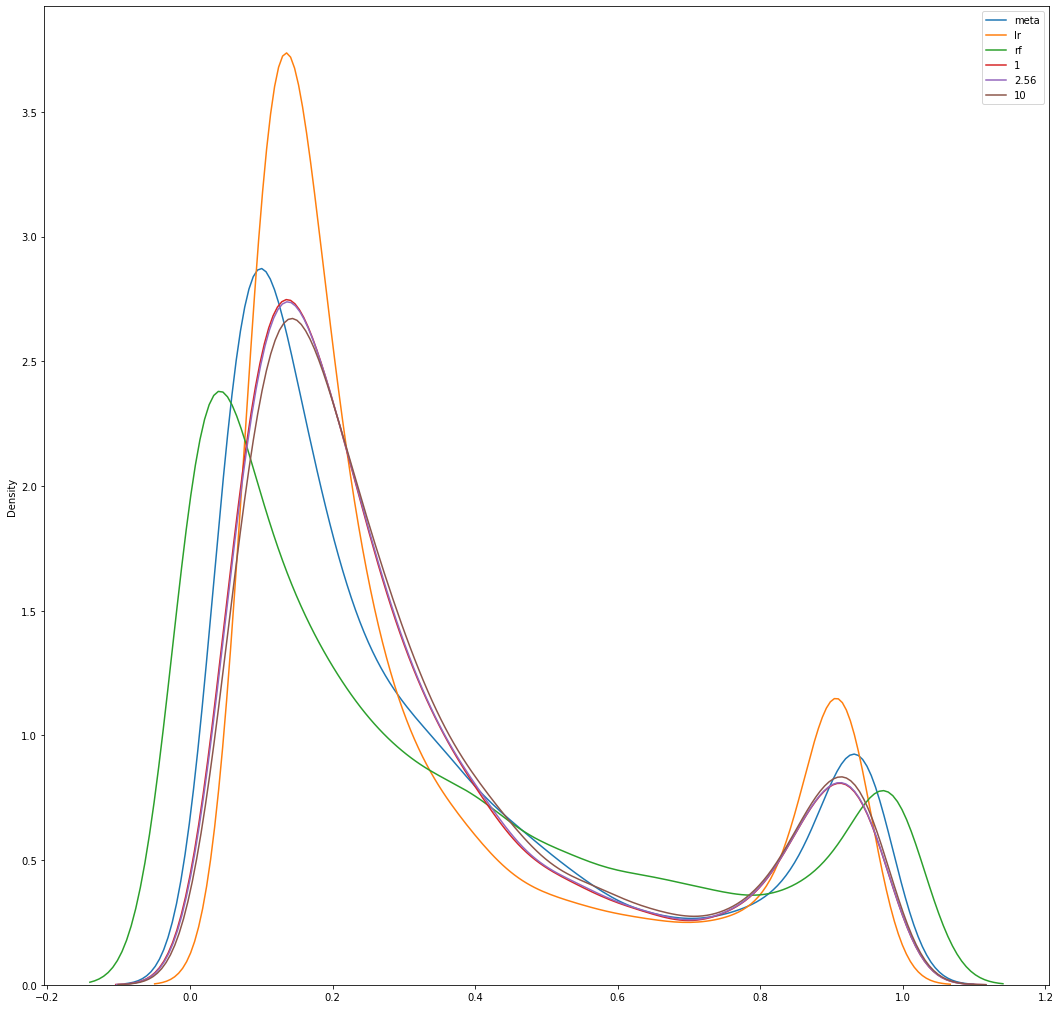

In [173]:
# power mean ensemble
# 각 prediction의 histogram을 보고, 적절한 p값을 찾는다.
plt.figure(figsize = (18, 18))
sns.distplot(np.mean(meta_preds, axis = 0), hist = False)
sns.distplot(lr_meta_pred[:,1], hist = False)
sns.distplot(rf_meta_pred[:,1], hist = False)
for i in [1, 2.56, 20]:
    pred_mean = (np.sum(np.array(preds)**i, axis=0) / 2)**(1/i)
    sns.distplot(pred_mean, hist = False)
plt.legend(['meta','lr','rf',1, 2.56, 10])
plt.show()

In [189]:
# 각 pred간의 상관관계를 분석하여, SOTA와 차이가 심한 모델은 성능이 좋지 않은 것으로 판단.
pd.concat([
    pd.DataFrame(np.sum(np.array(preds)**1, axis=0) / 2 )**(1/1), # 산술평균
    pd.DataFrame(np.sum(np.array(preds)**2.56, axis=0) / 2)**(1/2.56), # 지수평균
    pd.DataFrame(lr_meta_pred[:,1]), # stacking meta LR
#    pd.DataFrame(pred_mean),
    pd.DataFrame(rf_meta_pred[:,1]) # stacking meta RF
          ], axis = 1).corr()

,0,0,0,0,0
0,1.000000,0.999928,0.992178,0.955492,0.871219
0,0.999928,1.000000,0.992065,0.955412,0.871114
0,0.992178,0.992065,1.000000,0.957793,0.868801
0,0.955492,0.955412,0.957793,1.000000,0.970857
0,0.871219,0.871114,0.868801,0.970857,1.000000


In [ ]:
'''
RandomForest meta모델은 성능이 너무 안좋음.
기존 powermean ensemble했던 sota모델(0.844)와 유사하면서도 다른 분포를 갖는 LR meta model을 최종으로 선정
'''

In [191]:
pred_mean = lr_meta_pred[:,1]

# Submission

In [192]:
t = pd.Timestamp.now()
fname = f"{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"

sample_submssion = pd.read_csv('sample_submission.csv')

sample_submssion['problem'] = pred_mean.reshape(-1)

sample_submssion.to_csv(fname, index = False)
sample_submssion

,user_id,problem
0,30000,0.930406
1,30001,0.277297
2,30002,0.540960
3,30003,0.888317
4,30004,0.916237
...,...,...
14994,44994,0.176913
14995,44995,0.213327
14996,44996,0.755690
14997,44997,0.890591
